##### Student Name: Vaishnavi Vijay Ghawate
##### Student ID: 201779753

##### This python notebook contains script to implement groundnut crop disease detection system. The dataset used for this implemetation has been referenced in the project report. The instructions to run the following code have been given within each code cell. This implementation was done using platforms like Google Colab and Kaggle, hence path to datasets might differ for every editor. This project made use of GPUs for execution to help model train faster.

In [1]:
# These are the libraries needed for implementation.
import zipfile
from pathlib import Path
import os
import torch
import torch.utils.data as data
from torchvision.utils import make_grid
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, TensorDataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import cv2
import torchvision.transforms as tt
from torchvision.utils import save_image

In [2]:
#Check which device to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# If using Colab and data is on the Google Drive then following execution is required to connect to drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Execute if the data is in a zipped folder
# Unzip train.zip
with zipfile.ZipFile("/content/drive/MyDrive/Project_data/rawData.zip", "r") as zip_ref:
    zip_ref.extractall("rawData")

In [3]:
# Transformations applied on validation and test sets
data_transform = transforms.Compose([
    # Resize the images to 224x224
    transforms.Resize(size=(128, 128)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [4]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [5]:
# Transformations applied training set
transform2 = tt.Compose([tt.Resize((128,128)),
                         tt.RandomHorizontalFlip(),
                         tt.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(-10, 10)),
                         tt.ToTensor(),
                        ])

# If the raw data is being used, run the following cells

In [5]:
# Path should be chnaged to where the data is stored
data_dir = Path("/kaggle/input/cropped-data/data")

In [6]:
#To split the dataset into train and test
def split_dataset(dataset_dir, output_dir, test_split=0.3):
    class_names = os.listdir(dataset_dir)
    os.makedirs(output_dir, exist_ok=True)

    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        class_dir = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_dir)

        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=test_split, random_state=42)

        for image in train_images:
            shutil.copy(os.path.join(class_dir, image), os.path.join(train_dir, class_name))
        for image in test_images:
            shutil.copy(os.path.join(class_dir, image), os.path.join(test_dir, class_name))

# Specify the paths for input directory and output directory where the data folders of train and test will be created after the split
dataset_dir = '/kaggle/input/cropped-data/data'
output_dir = 'splitData10'

# Split the dataset
split_dataset(dataset_dir, output_dir)

In [8]:
# Modify the path to where the split data is stored (previous cell's output)
output_dir = '/kaggle/working/splitData10'

In [10]:
# transform2 containing flipping and random affine operations is applied to train data and data_transform which just resizes the image and converts it into a tensor is applied to test data
train_path = Path(f"{output_dir}/train")
test_path = Path(f"{output_dir}/test")
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_dataset = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=transform2, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_val_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform)

print(f"Train data:\n{train_dataset}\nTest data:\n{test_val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 6218
    Root location: /kaggle/working/splittedData10/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2669
    Root location: /kaggle/working/splittedData10/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_dataset.classes
class_names

In [12]:
# To define the split ratio for train-validation split. Here test dataset created previously was further divided to assign half of it to validation set
test_size = int(0.5 * len(test_val_data))
val_size = len(test_val_data) - test_size

# Split the dataset into train and validation sets
test_dataset, val_dataset = torch.utils.data.random_split(test_val_data, [test_size, val_size])

# If the pre-augmented data is being used, run the following cells till before the code cell for creation of dataloaders

In [6]:
# Modify the path to where the pre-augmented data is stored
data_dir = Path("/kaggle/input/augmented-data/Groundnut_Leaf_dataset")

In [8]:
# Since the pre-augmented data is already split into train and test, there is no need for split function. Hence, the data_dir, output_dir paths are the same
output_dir = '/kaggle/input/augmented-data/Groundnut_Leaf_dataset'

In [49]:
# Since the pre-augmented data had transformations already applied to it manually, there is no need to apply them again. Hence, just the data_tranform is performed
train_path = Path(f"{output_dir}/train")
test_path = Path(f"{output_dir}/test")
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_dataset = datasets.ImageFolder(root=test_path,
                                 transform=data_transform)

print(f"Train data:\n{train_dataset}\nTest data:\n{test_dataset}")

Train data:
Test data:
Dataset ImageFolder
    Number of datapoints: 2451
    Root location: /kaggle/input/augmented-data/Groundnut_Leaf_dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [11]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['early_leaf_spot_1',
 'early_rust_1',
 'healthy_leaf_1',
 'late_leaf_spot_1',
 'nutrition_deficiency_1',
 'rust_1']

In [12]:
# A validation set is created from the train set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Code hereafter is common for both the datasets, raw and pre-augmented

In [13]:
# Create data loaders for train and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)  #setting num_workers equal to number of cpu
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

In [15]:
#For different set of transforms
#train_dataset.dataset.transform = train_tfms

In [19]:
len(train_dataset)

6328

In [20]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images).permute(1, 2, 0))
        break

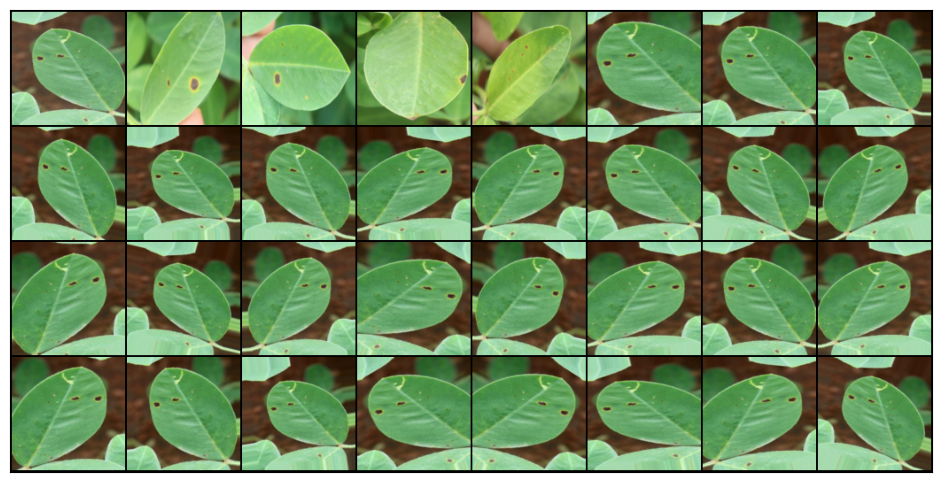

In [21]:
show_batch(test_loader)

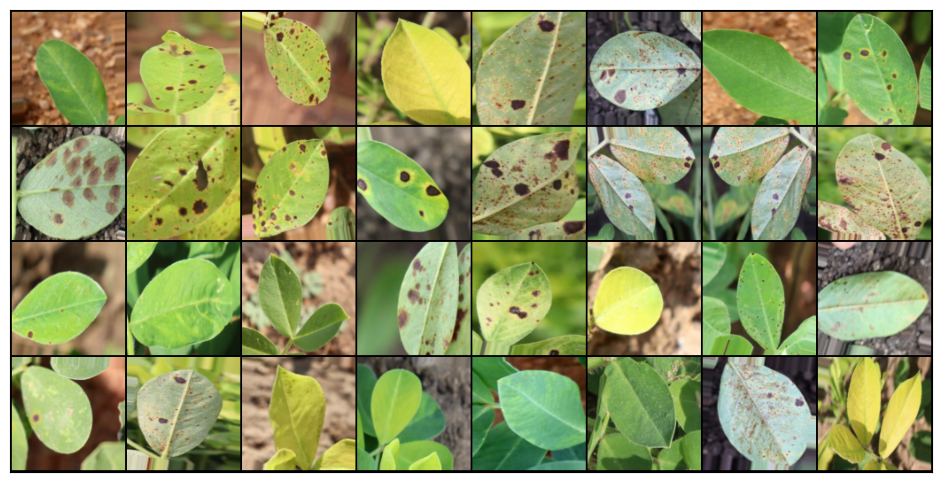

In [22]:
show_batch(train_loader)

In [23]:
#To shift dataloaders on GPU
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [24]:
# To shift dataloaders on GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [25]:
# Checking if dataloaders are working
img, label = next(iter(train_loader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


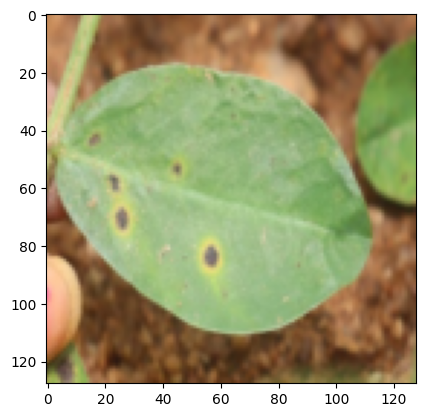

In [26]:
img, label = train_dataset[125]
plt.imshow(img.permute(1, 2, 0))

In [27]:
#Base class that can be used for any model to train and get accuracy
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# ResNetC Implementation

In [28]:
# Creation and instantiation of ResNetC
class ResNetC(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 3 x 128 x 128
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Output: 32 x 64 x 64
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Output: 64 x 32 x 32
        )
        
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Output: 128 x 16 x 16
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Output: 128*16*16 = 32768
            nn.Linear(128 * 16 * 16, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.classifier(out)
        return out

In [ ]:
# Instantiate the model and move it to the device
#If the raw data is being used, this configuration is correct since it has 5 classes
model = to_device(ResNetC(3, 5), device)
model

In [39]:
#If the pre-augmented data is being used, implement the following code lines. Here, the number of classes are 6 cause there are 6 categories in the pre-augmented dataset 
model = to_device(ResNetC(3, 6), device)
model


ResNetC(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5):

# Without One-Cycle Policy

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_fixed_lr(epochs, lr, model, train_loader, val_loader,
                 weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up optimizer with weight decay and fixed learning rate
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lr'] = lr  # Record the fixed learning rate
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Evaluate the model before training
history = [evaluate(model, val_loader)]

# Set hyperparameters
epochs = 50
lr = 0.0001  # Fixed learning rate
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [32]:
%%time
history += fit_fixed_lr(epochs, lr, model, train_loader, val_loader,
                        grad_clip=grad_clip,
                        weight_decay=weight_decay,
                        opt_func=opt_func)

Epoch [0], train_loss: 0.8800, val_loss: 0.4982, val_acc: 0.8032
Epoch [1], train_loss: 0.3911, val_loss: 0.4163, val_acc: 0.8406
Epoch [2], train_loss: 0.2431, val_loss: 0.3431, val_acc: 0.8810
Epoch [3], train_loss: 0.1733, val_loss: 0.2512, val_acc: 0.9094
Epoch [4], train_loss: 0.1010, val_loss: 0.2090, val_acc: 0.9234
Epoch [5], train_loss: 0.0773, val_loss: 0.1631, val_acc: 0.9473
Epoch [6], train_loss: 0.0679, val_loss: 0.2077, val_acc: 0.9212
Epoch [7], train_loss: 0.0444, val_loss: 0.1476, val_acc: 0.9473
Epoch [8], train_loss: 0.0573, val_loss: 0.1755, val_acc: 0.9361
Epoch [9], train_loss: 0.0267, val_loss: 0.1865, val_acc: 0.9317
Epoch [10], train_loss: 0.0250, val_loss: 0.1457, val_acc: 0.9461
Epoch [11], train_loss: 0.0253, val_loss: 0.2030, val_acc: 0.9240
Epoch [12], train_loss: 0.0513, val_loss: 0.1739, val_acc: 0.9398
Epoch [13], train_loss: 0.0242, val_loss: 0.1872, val_acc: 0.9292
Epoch [14], train_loss: 0.0184, val_loss: 0.1474, val_acc: 0.9498
Epoch [15], train_lo

# With One-Cycle Policy Implementation

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [41]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.794141173362732, 'val_acc': 0.16660712659358978}]

In [42]:
epochs = 50
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [43]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 1.3623, val_loss: 1.0537, val_acc: 0.6146
Epoch [1], train_loss: 0.9434, val_loss: 0.8285, val_acc: 0.7060
Epoch [2], train_loss: 0.7467, val_loss: 0.6843, val_acc: 0.7393
Epoch [3], train_loss: 0.5925, val_loss: 0.5906, val_acc: 0.7869
Epoch [4], train_loss: 0.4717, val_loss: 0.4681, val_acc: 0.8318
Epoch [5], train_loss: 0.3764, val_loss: 0.4041, val_acc: 0.8476
Epoch [6], train_loss: 0.3025, val_loss: 0.3300, val_acc: 0.8815
Epoch [7], train_loss: 0.2310, val_loss: 0.3476, val_acc: 0.8698
Epoch [8], train_loss: 0.1752, val_loss: 0.2509, val_acc: 0.9025
Epoch [9], train_loss: 0.1362, val_loss: 0.2392, val_acc: 0.9179
Epoch [10], train_loss: 0.1098, val_loss: 0.4708, val_acc: 0.8567
Epoch [11], train_loss: 0.0994, val_loss: 0.2559, val_acc: 0.9192
Epoch [12], train_loss: 0.0722, val_loss: 0.2581, val_acc: 0.9098
Epoch [13], train_loss: 0.0520, val_loss: 0.2125, val_acc: 0.9298
Epoch [14], train_loss: 0.0510, val_loss: 0.1673, val_acc: 0.9361
Epoch [15], train_lo

# To check accuracy on test set

In [45]:
#To check overall loss and accuracy of test set
test_loader = DeviceDataLoader(DataLoader(test_dataset, 32*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.24634666740894318, 'val_acc': 0.8982371687889099}

# To print predictions

In [46]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: early_leaf_spot_1 , Predicted: 0


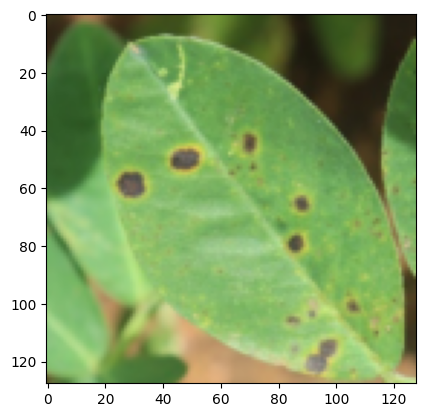

In [51]:
#To test with individual image in validation set
img, label = val_dataset[550]
plt.imshow(img.permute(1, 2, 0))
print('Label:', class_names[label], ', Predicted:', predict_image(img, model))

Label: early_rust_1 , Predicted: 1


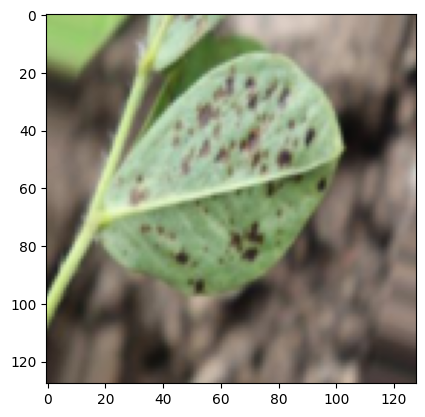

In [53]:
#To test with individual image in test set
img, label = test_dataset[550]
plt.imshow(img.permute(1, 2, 0))
print('Label:', class_names[label], ', Predicted:', predict_image(img, model))

# For printing evaluation metrics

In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')

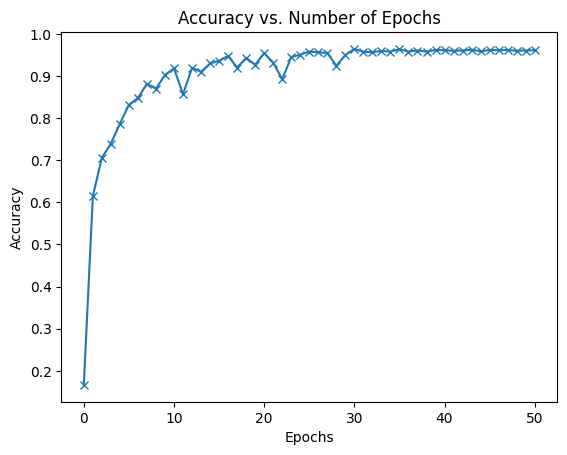

In [55]:
plot_accuracies(history)

In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of Epochs')

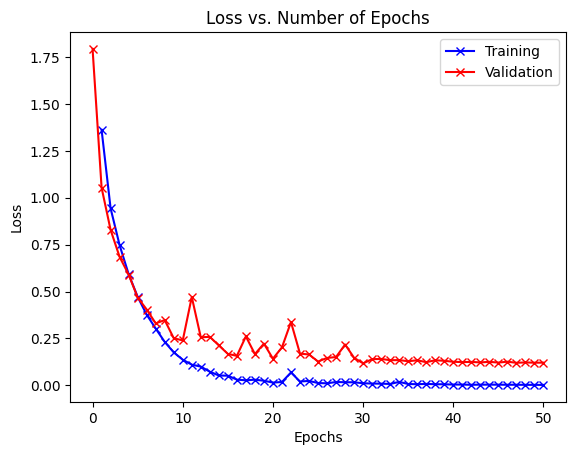

In [57]:
plot_losses(history)

In [58]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, color='green')
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number')

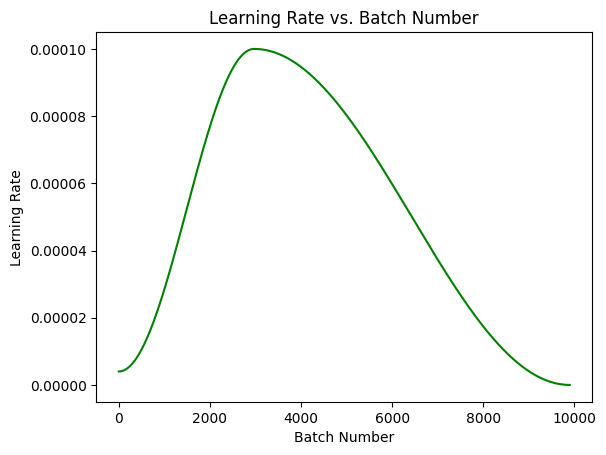

In [59]:
plot_lrs(history)

In [60]:
#Calculating precision, recall, f1 score
def calculate_metrics(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for batch in val_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all predictions and labels from all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Get the predicted class by taking the argmax
    _, all_preds = torch.max(all_preds, dim=1)
    
    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return precision, recall, f1, conf_matrix


In [61]:
import seaborn as sns

#Plotting confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [62]:
precision, recall, f1, conf_matrix = calculate_metrics(model, val_loader)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9619
Recall: 0.9614
F1 Score: 0.9615


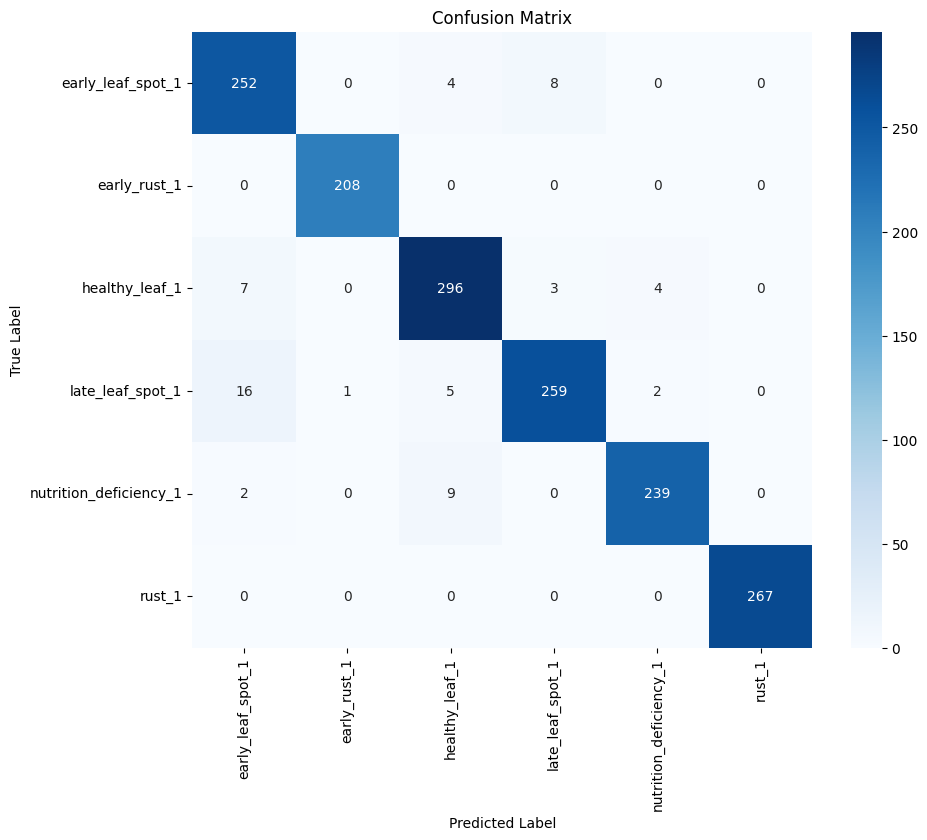

In [63]:
plot_confusion_matrix(conf_matrix, class_names)

# To print XAI heatmap

Label:  3
Features shape: torch.Size([1, 128, 32, 32])
Gradients shape: torch.Size([1, 128, 32, 32])


<Figure size 1000x1000 with 0 Axes>

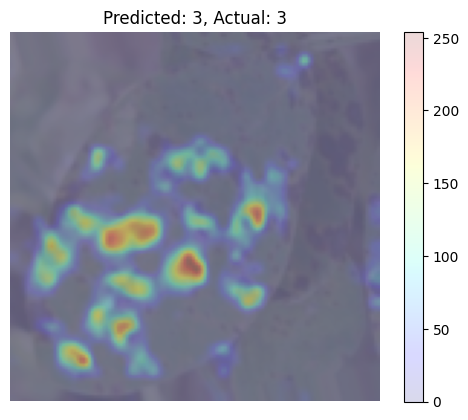

In [86]:
# Define the SaveFeatures class to hook the features
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

# Define the SaveGradients class to hook the gradients
class SaveGradients:
    def __init__(self, module):
        self.hook = module.register_backward_hook(self.hook_fn)  # Revert to register_backward_hook
        self.gradients = None
    
    def hook_fn(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]
    
    def remove(self):
        self.hook.remove()

# Define the function to compute Grad-CAM
def get_gradcam(model, image, class_idx, target_layer):
    model.eval()
    
    # Register hooks
    features_hook = SaveFeatures(target_layer)
    gradients_hook = SaveGradients(target_layer)
    
    # Forward pass
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image)
    pred_class = output.argmax().item()
    
    # Backward pass
    model.zero_grad()
    class_loss = output[:, class_idx].sum()  # Simplified loss calculation for targeted backpropagation
    class_loss.backward()
    
    # Get features and gradients
    features = features_hook.features
    gradients = gradients_hook.gradients
    
    # Debug prints to verify shapes
    print(f"Features shape: {features.shape}")
    print(f"Gradients shape: {gradients.shape}")
    
    # Compute weights
    weights = gradients.mean(dim=[2, 3], keepdim=True)
    
    # Compute Grad-CAM
    gradcam = F.relu((weights * features).sum(dim=1)).squeeze().detach().cpu().numpy()
    
    # Normalize heatmap
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())
    
    features_hook.remove()
    gradients_hook.remove()
    
    return gradcam, pred_class

# Define the function to show Grad-CAM
def show_gradcam(gradcam, image, ax=None, alpha_image=0.85, alpha_heatmap=0.15):  
    if ax is None:
        fig, ax = plt.subplots()

    # Resize the Grad-CAM heatmap to match the image size
    gradcam_resized = np.array(Image.fromarray(gradcam).resize((image.shape[2], image.shape[1])))

    # Ensure values are non-negative before applying the power
    gradcam_resized = np.clip(gradcam_resized, 0, None)  # Clip negative values to zero

    # Apply non-linear transformation to subtly emphasize warmer colors
    gradcam_resized = gradcam_resized ** 1.5  # Adjust to 1.5 to balance the effect

    # Normalize the resized heatmap to range [0, 255] for better visualization
    gradcam_resized = np.uint8(255 * gradcam_resized / gradcam_resized.max())  # Normalize after power transformation

    # Convert the heatmap to an RGB image using a colormap
    heatmap = plt.get_cmap('jet')(gradcam_resized)[:, :, :3]  # Use only RGB channels, drop alpha

    # Blend the heatmap with the original image
    image_np = image.permute(1, 2, 0).cpu().numpy()
    blended_image = (alpha_image * image_np + alpha_heatmap * heatmap).clip(0, 1)

    # Display the blended image
    ax.imshow(blended_image)
    ax.axis('off')
    plt.colorbar(ax.imshow(gradcam_resized, cmap='jet', alpha=alpha_heatmap), ax=ax)


# Define the function to denormalize images
def denormalize(images, means, stds, device):
    means = torch.tensor(means, device=device).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds, device=device).reshape(1, 3, 1, 1)
    return (images * stds + means).squeeze(0)

# Get a single image from validation set
image, label = val_dataset[14]
image = image.to(device)
print('Label: ', label)

# Select the target layer for Grad-CAM
target_layer = model.conv3[0]  # Last conv layer before classifier

# Compute Grad-CAM
gradcam, pred_class = get_gradcam(model, image, label, target_layer)

# Visualize Grad-CAM
plt.figure(figsize=(10, 10))
show_gradcam(gradcam, denormalize(image, *stats, device))
plt.title(f'Predicted: {pred_class}, Actual: {label}')
plt.show()


Label: late_leaf_spot_1 , Predicted: 3


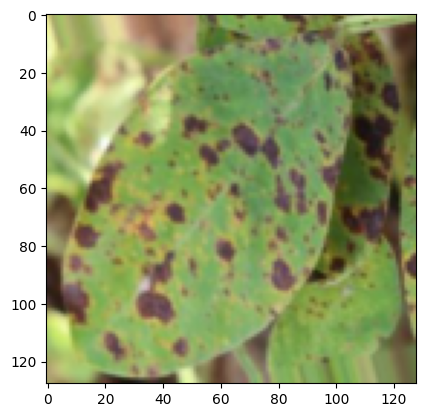

In [87]:
# Original image for which the heatmap is shown above
img, label = val_dataset[14]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', class_names[label], ', Predicted:', predict_image(img, model))

# Code hereafter should be ignored. It contains the code tested, modified and disregarded from final execution. It is kept for future referencing. 

In [ ]:
# To save the trained model
torch.save(model.state_dict(), 'CropModel2_val71_test66.pth')

In [17]:
# Data transforms (normalization & data augmentation)
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [18]:
# def denormalize(images, means, stds, device):
#     means = torch.tensor(means, device=device).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds, device=device).reshape(1, 3, 1, 1)
#     return images * stds + means

In [53]:
test_loader = DeviceDataLoader(test_loader, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10541219264268875, 'val_acc': 0.9657738208770752}

Label: rust , Predicted: rust


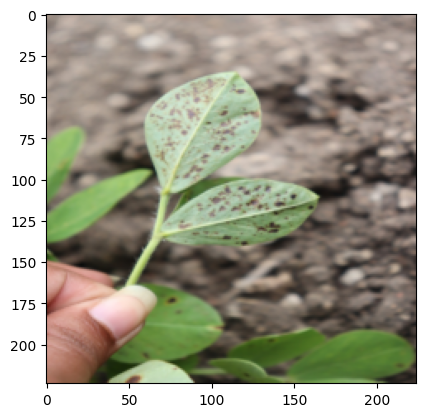

In [51]:
img, label = val_dataset[62]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: healthy leaf , Predicted: healthy leaf


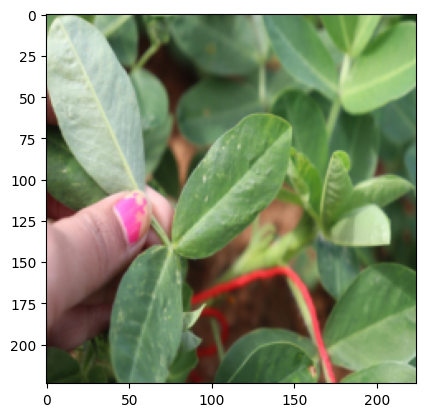

In [37]:
img, label = val_dataset[86]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: early_leaf_spot , Predicted: early_leaf_spot


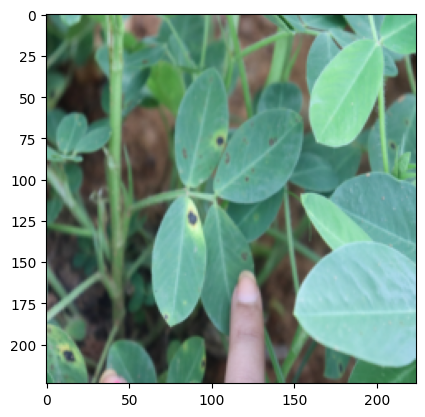

In [38]:
img, label = val_dataset[245]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: healthy leaf , Predicted: healthy leaf


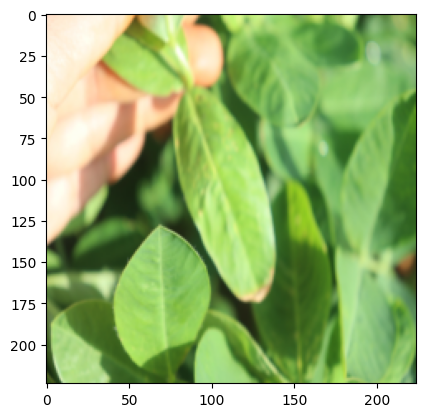

In [61]:
img, label = val_dataset[14]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: early_leaf_spot , Predicted: healthy leaf


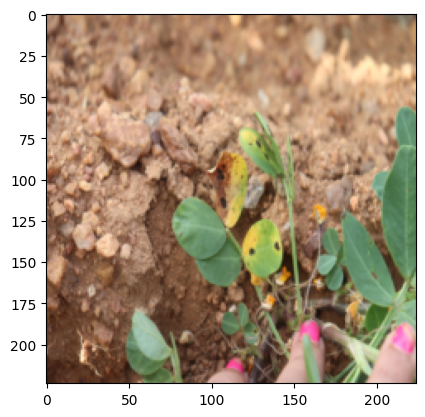

In [42]:
img, label = test_data[5]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [52]:
torch.save(model.state_dict(), 'CropModel_OG_NT_ResNet9_30.pth')

In [20]:
#Loading the model from saved state
model = to_device(ResNet9(3, 6), device)

In [22]:
model.load_state_dict(torch.load('/kaggle/input/cropmodel/CropModel2_val98.pth'))

<All keys matched successfully>

Label: early_leaf_spot , Predicted: nutrition deficiency


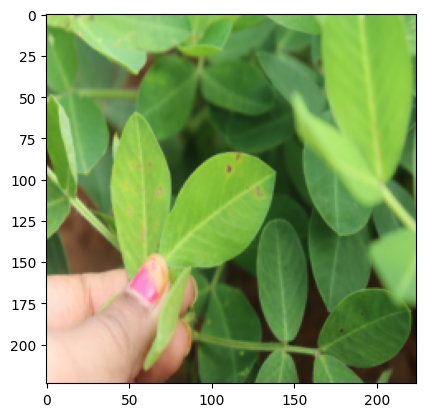

In [111]:
#Evaluating the model on test set
img, label = test_data[34]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Final Testing Grad-CAM

In [93]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Grad-CAM class definition
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        forward_hook = self.target_layer.register_forward_hook(forward_hook)
        backward_hook = self.target_layer.register_backward_hook(backward_hook)
        self.hooks.append(forward_hook)
        self.hooks.append(backward_hook)

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor.requires_grad = True

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()  # Get the index of the highest score class
        score = output[:, class_idx]

        self.model.zero_grad()
        score.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.size(1)):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap.detach().numpy(), 0)
        heatmap = heatmap / np.max(heatmap)
        return heatmap

# Function to overlay the heatmap on the image
def apply_colormap_on_image(org_img, activation, colormap_name='jet'):
    colormap = plt.get_cmap(colormap_name)
    heatmap = colormap(activation)
    heatmap = np.delete(heatmap, 3, axis=2)
    heatmap = np.uint8(255 * heatmap)
    overlayed_img = heatmap * 0.4 + org_img
    return overlayed_img

# To visualize a single image of your choice
def visualize_image_with_gradcam(model, image, stats, target_layer):
    # Ensure the image tensor has 3 dimensions: [C, H, W]
    if image.dim() == 3:
        # Denormalize the image for visualization
        image_denorm = denormalize(image.unsqueeze(0), stats[0], stats[1], device)
        input_image = image_denorm[0].permute(1, 2, 0).cpu().numpy()  # Convert from [C, H, W] to [H, W, C] for visualization
    else:
        raise ValueError(f"Input image tensor does not have 3 dimensions (C, H, W). Current shape: {image.shape}")

    # Instantiate the GradCAM object
    grad_cam = GradCAM(model, target_layer)

    # Generate the Grad-CAM heatmap
    heatmap = grad_cam.generate(image.unsqueeze(0))

    # Remove hooks
    grad_cam.remove_hooks()

    # Move heatmap to CPU and convert to NumPy
    heatmap = heatmap.cpu().numpy()

    # Visualize the Grad-CAM
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_image)

    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM')
    cam_image = apply_colormap_on_image(input_image, heatmap)
    plt.imshow(cam_image)
    plt.show()


# to visualize the first image from validation loader
images, labels = next(iter(val_loader))

# Choose the specific image to visualize (e.g., the first image)
chosen_image = images[0]

# Specify the last convolutional layer as the target layer for Grad-CAM
target_layer = model.conv4[0]  # Last convolutional layer

# Call the function to visualize the chosen image
visualize_image_with_gradcam(model, chosen_image, stats, target_layer)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

# XAI with Grad-CAM

In [44]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, index=None):
        self.model.zero_grad()
        output = self.model(x)

        if index is None:
            index = torch.argmax(output)

        target = output[0][index]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(len(pooled_gradients)):
            activations[i] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        return heatmap, output

def visualize_cam(mask, img, alpha=1.0):
    heatmap = mask.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = img.permute(1, 2, 0).numpy()
    img = img - np.min(img)
    img = img / np.max(img)
    plt.imshow(img)
    plt.show()

    superimposed_img = heatmap * alpha + img
    superimposed_img = superimposed_img / np.max(superimposed_img)

    return superimposed_img

Label: rust , Predicted: rust


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


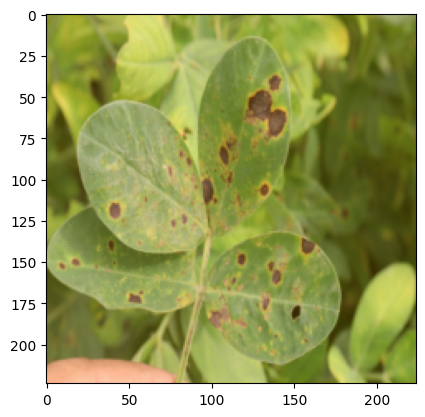

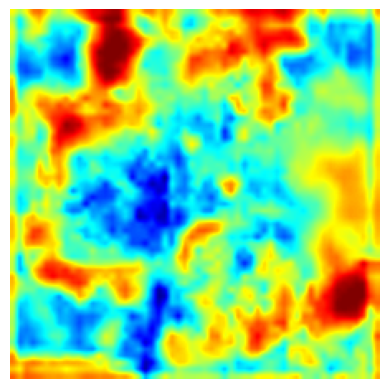

In [45]:
# Ensure all tensors are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose the layer for which you want to visualize Grad-CAM
target_layer = model.conv4[0]

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Function to visualize Grad-CAM for a specific image index
def visualize_image(val_loader, image_index):
    # Find the batch that contains the specified image index
    current_index = 0
    for images, _ in val_loader:
        batch_size = images.size(0)
        if current_index + batch_size > image_index:
            image_in_batch_index = image_index - current_index
            sample_image = images[image_in_batch_index].unsqueeze(0).to(device)
            break
        current_index += batch_size

    # Get the Grad-CAM mask
    mask, _ = grad_cam(sample_image)

    # Denormalize the input image for visualization
    sample_image_denorm = denormalize(sample_image, stats[0], stats[1], device).squeeze().cpu()

    # Visualize the Grad-CAM
    cam_image = visualize_cam(mask, sample_image_denorm)

    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

# Specify the image index to visualize
image_index = 65 
img, label = val_dataset[image_index]
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
visualize_image(val_loader, image_index)


# Still Testing XAI

Label: rust , Predicted: rust


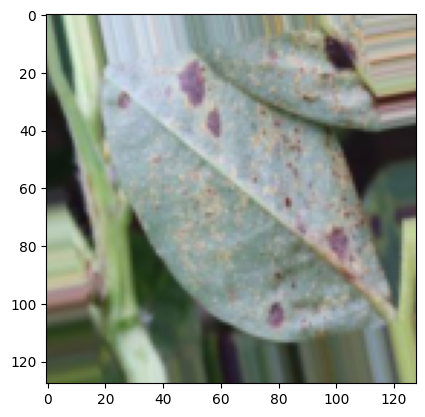

In [106]:
img, label = val_dataset[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

# Trying to Enhance Above XAI

Label:  4
Features shape: torch.Size([1, 128, 32, 32])
Gradients shape: torch.Size([1, 128, 32, 32])


<Figure size 1000x1000 with 0 Axes>

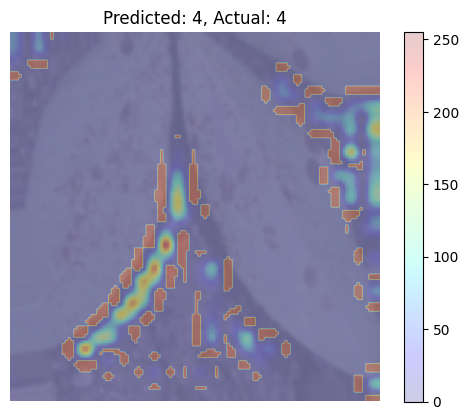

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# # Define the SaveFeatures class to hook the features
# class SaveFeatures:
#     def __init__(self, module):
#         self.hook = module.register_forward_hook(self.hook_fn)
#         self.features = None
    
#     def hook_fn(self, module, input, output):
#         self.features = output
    
#     def remove(self):
#         self.hook.remove()

# # Define the SaveGradients class to hook the gradients
# class SaveGradients:
#     def __init__(self, module):
#         self.hook = module.register_backward_hook(self.hook_fn)
#         self.gradients = None
    
#     def hook_fn(self, module, grad_in, grad_out):
#         self.gradients = grad_out[0]
    
#     def remove(self):
#         self.hook.remove()

# # Define the function to compute Grad-CAM
# def get_gradcam(model, image, class_idx, target_layer):
#     model.eval()
    
#     # Register hooks
#     features_hook = SaveFeatures(target_layer)
#     gradients_hook = SaveGradients(target_layer)
    
#     # Forward pass
#     image = image.unsqueeze(0)  # Add batch dimension
#     output = model(image)
#     pred_class = output.argmax().item()
    
#     # Backward pass
#     model.zero_grad()
#     class_loss = F.cross_entropy(output, torch.tensor([class_idx], device=output.device))
#     class_loss.backward()
    
#     # Get features and gradients
#     features = features_hook.features
#     gradients = gradients_hook.gradients
    
#     # Debug prints to verify shapes
#     print(f"Features shape: {features.shape}")
#     print(f"Gradients shape: {gradients.shape}")
    
#     # Compute weights
#     weights = gradients.mean(dim=[2, 3], keepdim=True)
    
#     # Compute Grad-CAM
#     gradcam = F.relu((weights * features).sum(dim=1)).squeeze().detach().cpu().numpy()
    
#     # Normalize heatmap
#     gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())
    
#     features_hook.remove()
#     gradients_hook.remove()
    
#     return gradcam, pred_class

# # Define the function to show Grad-CAM
# def show_gradcam(gradcam, image, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
#     heatmap = ax.imshow(gradcam, cmap='jet', alpha=0.5)
#     ax.imshow(image.permute(1, 2, 0).cpu().numpy(), alpha=0.5)
#     ax.axis('off')
#     plt.colorbar(heatmap, ax=ax)

# # Define the function to denormalize images
# def denormalize(images, means, stds, device):
#     means = torch.tensor(means, device=device).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds, device=device).reshape(1, 3, 1, 1)
#     return (images * stds + means).squeeze(0)


# # Get a single image from validation set
# image, label = val_dataset[65]
# image = image.to(device)
# print('test ', label)

# # Select the target layer for Grad-CAM
# target_layer = model.conv4[0]  # Last conv layer before classifier

# # Compute Grad-CAM
# gradcam, pred_class = get_gradcam(model, image, label, target_layer)

# visualize_image(val_loader, image_index)

# # Visualize Grad-CAM
# plt.figure(figsize=(10, 10))
# show_gradcam(gradcam, denormalize(image, *stats, device))
# plt.title(f'Predicted: {pred_class}, Actual: {label}')
# plt.show()

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Define the SaveFeatures class to hook the features
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

# Define the SaveGradients class to hook the gradients
class SaveGradients:
    def __init__(self, module):
        self.hook = module.register_backward_hook(self.hook_fn)
        self.gradients = None
    
    def hook_fn(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]
    
    def remove(self):
        self.hook.remove()

# Define the function to compute Grad-CAM
def get_gradcam(model, image, class_idx, target_layer):
    model.eval()
    
    # Register hooks
    features_hook = SaveFeatures(target_layer)
    gradients_hook = SaveGradients(target_layer)
    
    # Forward pass
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image)
    pred_class = output.argmax().item()
    
    # Backward pass
    model.zero_grad()
    class_loss = F.cross_entropy(output, torch.tensor([class_idx], device=output.device))
    class_loss.backward()
    
    # Get features and gradients
    features = features_hook.features
    gradients = gradients_hook.gradients
    
    # Debug prints to verify shapes
    print(f"Features shape: {features.shape}")
    print(f"Gradients shape: {gradients.shape}")
    
    # Compute weights
    weights = gradients.mean(dim=[2, 3], keepdim=True)
    
    # Compute Grad-CAM
    gradcam = F.relu((weights * features).sum(dim=1)).squeeze().detach().cpu().numpy()
    
    # Normalize heatmap
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())
    
    features_hook.remove()
    gradients_hook.remove()
    
    return gradcam, pred_class

# Define the function to show Grad-CAM
def show_gradcam(gradcam, image, ax=None, alpha_image=0.8, alpha_heatmap=0.2):
    if ax is None:
        fig, ax = plt.subplots()

    # Resize the Grad-CAM heatmap to match the image size
    gradcam_resized = np.array(Image.fromarray(gradcam).resize((image.shape[2], image.shape[1])))

    # Normalize the resized heatmap to range [0, 255] for better visualization
    gradcam_resized = np.uint8(255 * gradcam_resized)

    # Convert the heatmap to an RGB image using a colormap
    heatmap = plt.get_cmap('jet')(gradcam_resized)[:, :, :3]  # Use only RGB channels, drop alpha

    # Lighten the heatmap by adding a constant value
    heatmap_light = np.clip(heatmap + 0.5, 0, 1)

    # Blend the heatmap with the original image
    image_np = image.permute(1, 2, 0).cpu().numpy()
    blended_image = (alpha_image * image_np + alpha_heatmap * heatmap_light).clip(0, 1)

    # Display the blended image
    ax.imshow(blended_image)
    ax.axis('off')
    plt.colorbar(ax.imshow(gradcam_resized, cmap='jet', alpha=alpha_heatmap), ax=ax)

# Define the function to denormalize images
def denormalize(images, means, stds, device):
    means = torch.tensor(means, device=device).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds, device=device).reshape(1, 3, 1, 1)
    return (images * stds + means).squeeze(0)


# Get a single image from validation set
image, label = val_dataset[200]
image = image.to(device)
print('Label: ', label)

# Select the target layer for Grad-CAM
target_layer = model.conv3[0]  # Last conv layer before classifier

# Compute Grad-CAM
gradcam, pred_class = get_gradcam(model, image, label, target_layer)

# Visualize Grad-CAM
plt.figure(figsize=(10, 10))
show_gradcam(gradcam, denormalize(image, *stats, device))
plt.title(f'Predicted: {pred_class}, Actual: {label}')
plt.show()


Label: healthy leaf , Predicted: healthy leaf


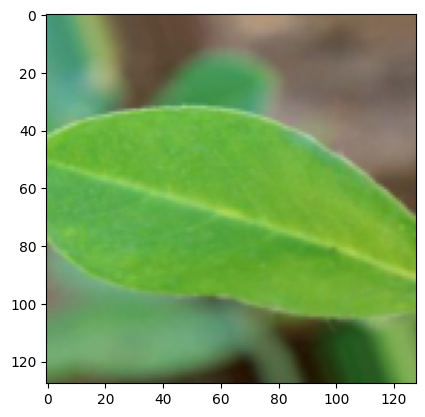

In [77]:
img, label = val_dataset[92]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

### Another XAI Trial

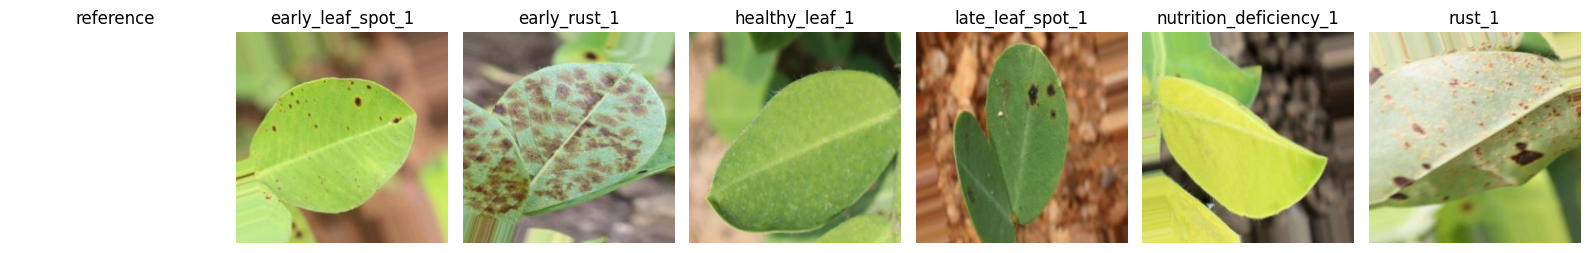

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.55 GiB. GPU 0 has a total capacty of 14.74 GiB of which 2.12 GiB is free. Process 2418 has 12.62 GiB memory in use. Of the allocated memory 10.07 GiB is allocated by PyTorch, and 2.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [63]:
# Save an example for each category in a dict
images_dict = dict()
for images, labels in train_loader:
    for image, label in zip(images, labels):
        label = label.item()
        if len(images_dict) == 6:
            break
        if label not in images_dict:
            images_dict[label] = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to numpy and adjust dimensions
    if len(images_dict) == 6:
        break

# Function to plot images
def plot_categories(images):
    fig, axes = plt.subplots(1, 7, figsize=(16, 15))
    axes = axes.flatten()

    # Plot an empty canvas
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')

    # Plot an image for every category
    for k, v in images.items():
        ax = axes[k+1]
        ax.imshow(v)
        ax.set_title(f"{class_names[k]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Use the function to plot
plot_categories(images_dict)

# Take a random sample of 5000 training images
all_train_images = torch.cat([batch[0] for batch in train_loader])
background = all_train_images[torch.randint(0, all_train_images.size(0), (100,))]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

# Save an example of each class from the test set
x_test_dict = dict()
for images, labels in test_loader:
    for image, label in zip(images, labels):
        label = label.item()
        if len(x_test_dict) == 6:
            break
        if label not in x_test_dict:
            x_test_dict[label] = image.squeeze().cpu().numpy()
    if len(x_test_dict) == 6:
        break

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.stack(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

# Compute predictions in smaller batches to avoid OOM errors
model.eval()
batch_size = 1  # Adjust as needed to fit in memory
predictions = []

with torch.no_grad():
    for i in range(0, len(x_test_each_class), batch_size):
        batch = torch.tensor(x_test_each_class[i:i + batch_size]).permute(0, 3, 1, 2).cuda()  # Convert to tensor and permute dimensions
        batch_predictions = model(batch)
        batch_predictions = torch.nn.functional.softmax(batch_predictions, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)
        
predictions = np.array(predictions)

# Apply argmax to get predicted class
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

# Compute shap values using DeepExplainer instance in smaller batches
shap_values = []
for i in range(0, len(x_test_each_class), batch_size):
    batch = torch.tensor(x_test_each_class[i:i + batch_size]).permute(0, 3, 1, 2).cuda()
    batch_shap_values = e.shap_values(batch)
    shap_values.extend(batch_shap_values)
    
shap_values = np.array(shap_values)

# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]

# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)

# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]

# Print (ordered) top 3 classes
for i in list(top_coat_args):
    print(class_names[i])

# GAN Trial 1

In [42]:
# Hyperparameters
image_size = 224
num_classes = 6
latent_dim = 100
ngf = 64
ndf = 64
num_epochs = 10

# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        # Conditional input layer
        self.label_emb = nn.Embedding(nc, nz)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # Input: (nz + nz) x 1 x 1
            *block(nz * 2, ngf * 16, normalize=False),
            *block(ngf * 16, ngf * 8),
            *block(ngf * 8, ngf * 4),
            *block(ngf * 4, ngf * 2),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, label):
        # Concatenate noise and embedded label
        emb = self.label_emb(label).view(-1, self.nz, 1, 1)
        input = torch.cat([noise, emb], 1)
        return self.model(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.nc = nc

        # Conditional input layer
        self.label_emb = nn.Embedding(nc, ndf * 4)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # Input: (nc + ndf) x 224 x 224
            *block(nc + ndf, ndf, normalize=False),
            *block(ndf, ndf * 2),
            *block(ndf * 2, ndf * 4),
            *block(ndf * 4, ndf * 8),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, label):
        # Concatenate image and embedded label
        emb = self.label_emb(label).view(-1, self.ndf * 4, 1, 1)
        emb = emb.repeat(1, 1, img.size(2), img.size(3))
        input = torch.cat([img, emb], 1)
        return self.model(input)

In [43]:
# Initialize models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator(latent_dim, ngf, num_classes).to(device)
netD = Discriminator(ndf, num_classes).to(device)

# Initialize optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(train_loader, 0):
        real_data = data.to(device)
        batch_size = real_data.size(0)

        # Train discriminator
        netD.zero_grad()

        # Real images
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        output = netD(real_data, labels).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        fake = netG(noise, fake_labels)
        label.fill_(0)
        output = netD(fake.detach(), fake_labels).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train generator
        netG.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        output = netD(fake, fake_labels).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

RuntimeError: Given groups=1, weight of size [64, 70, 4, 4], expected input[32, 259, 224, 224] to have 70 channels, but got 259 channels instead

# GAN Trial

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 50)
        self.model = nn.Sequential(
            nn.Conv2d(3 + 1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embeddings = self.label_embedding(labels).view(labels.size(0), 1, 1, 50)
        label_embeddings = label_embeddings.expand(-1, -1, 224, 224)
        x = torch.cat((x, label_embeddings), dim=1)
        return self.model(x)

In [ ]:
latent_size = 100  # Define latent size

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_size, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.latent_size = latent_size
        self.num_classes = num_classes

        self.label_embedding = nn.Embedding(num_classes, 50)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size + 50, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, labels):
        label_embeddings = self.label_embedding(labels).view(labels.size(0), 50, 1, 1)
        x = torch.cat((x, label_embeddings), dim=1)
        return self.model(x)

In [ ]:
def train_discriminator(real_images, labels, opt_d):
    opt_d.zero_grad()

    real_images = real_images.to(device)
    labels = labels.to(device)
    real_preds = discriminator(real_images, labels)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
    fake_images = generator(latent, labels)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images, labels)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g, num_classes):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    labels = torch.randint(0, num_classes, (batch_size,), device=device)
    fake_images = generator(latent, labels)

    preds = discriminator(fake_images, labels)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item(), fake_images, labels

def save_samples(index, latent_tensors, labels, directory='generated_data', show=True):
    latent_tensors = latent_tensors.to(device)
    labels = labels.to(device)
    fake_images = generator(latent_tensors, labels)

    for i, (image, label) in enumerate(zip(fake_images, labels)):
        class_dir = os.path.join(directory, str(label.item()))
        os.makedirs(class_dir, exist_ok=True)

        fake_fname = 'generated-image-{0:0=4d}.png'.format(index * len(fake_images) + i)
        save_image(denorm(image), os.path.join(class_dir, fake_fname))
        print('Saving', fake_fname, 'to', class_dir)

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def fit(epochs, lr, num_classes, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            labels = torch.randint(0, num_classes, (real_images.size(0),), device=device)
            loss_d, real_score, fake_score = train_discriminator(real_images, labels, opt_d)
            loss_g, fake_images, labels = train_generator(opt_g, num_classes)

            latent_tensors = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            save_samples(epoch + start_idx, latent_tensors, labels, show=False)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
import torchvision.transforms as T

# Define your transformations
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
from tqdm import tqdm

# Define constants
latent_size = 100
batch_size = 32  # or any batch size that fits your GPU memory
epochs = 20
lr = 0.0001
num_classes = 5
sample_dir = 'generated'

# Ensure the model is on the correct device
discriminator = ConditionalDiscriminator
generator = ConditionalGenerator(latent_size, num_classes).to(device)

# Create a fixed latent vector and labels for generating images
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

# Fit the model
losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr, num_classes)

# Evaluate the model
for real_images, _ in tqdm(test_loader):
    real_images = real_images.to(device)
    with torch.no_grad():
        real_preds = discriminator(real_images)
        print('Real images accuracy:', torch.mean(real_preds).item())
    break

TypeError: Module.parameters() missing 1 required positional argument: 'self'

In [ ]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, class_dim, img_shape):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(class_dim, class_dim).cuda()

        self.model = nn.Sequential(
            nn.Linear(latent_dim + class_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )

    def forward(self, z, labels):
        gen_input = torch.cat((self.label_emb(labels), z), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, class_dim, img_shape):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(class_dim, class_dim).cuda()

        self.model = nn.Sequential(
            nn.Linear(np.prod(img_shape) + class_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

# Hyperparameters
latent_dim = 100
class_dim = 5  # Number of classes
img_shape = (3, 224, 224)
lr = 0.0001
b1 = 0.5
b2 = 0.999
batch_size = 32
n_epochs = 20

# Initialize generator and discriminator
generator = Generator(latent_dim, class_dim, img_shape).cuda()
discriminator = Discriminator(class_dim, img_shape).cuda()

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Create directory for saving generated images
os.makedirs("images", exist_ok=True)

# Training loop
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()

        # Configure input
        real_imgs = imgs.cuda()
        labels = labels.cuda()

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), latent_dim).cuda()
        gen_labels = torch.randint(0, class_dim, (imgs.size(0),)).cuda()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(train_loader), d_loss.item(), g_loss.item())
        )

    # Save generated images
    save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)

[Epoch 0/20] [Batch 0/62] [D loss: 0.695072] [G loss: 0.682307]

[Epoch 0/20] [Batch 1/62] [D loss: 0.357165] [G loss: 0.691498]

[Epoch 0/20] [Batch 2/62] [D loss: 0.331457] [G loss: 0.725384]

[Epoch 0/20] [Batch 3/62] [D loss: 0.311313] [G loss: 0.770430]

[Epoch 0/20] [Batch 4/62] [D loss: 0.279794] [G loss: 0.836676]

[Epoch 0/20] [Batch 5/62] [D loss: 0.254916] [G loss: 0.925501]

[Epoch 0/20] [Batch 6/62] [D loss: 0.222630] [G loss: 1.058966]

[Epoch 0/20] [Batch 7/62] [D loss: 0.189097] [G loss: 1.170769]

[Epoch 0/20] [Batch 8/62] [D loss: 0.159685] [G loss: 1.329706]

[Epoch 0/20] [Batch 9/62] [D loss: 0.140269] [G loss: 1.463197]

[Epoch 0/20] [Batch 10/62] [D loss: 0.126432] [G loss: 1.580306]

[Epoch 0/20] [Batch 11/62] [D loss: 0.114500] [G loss: 1.631017]

[Epoch 0/20] [Batch 12/62] [D loss: 0.106631] [G loss: 1.670381]

[Epoch 0/20] [Batch 13/62] [D loss: 0.106890] [G loss: 1.624456]

[Epoch 0/20] [Batch 14/62] [D loss: 0.110590] [G loss: 1.562628]

[Epoch 0/20] [Batch 

In [ ]:
# Utility function for creating convolutional blocks
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#               nn.BatchNorm2d(out_channels),
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

# # ResNet5 class aligned with ImageClassificationBase
# class ResNet5(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()

#         # First convolutional layer
#         self.conv1 = conv_block(in_channels, 32)

#         # Second convolutional layer with pooling
#         self.conv2 = conv_block(32, 64, pool=True)

#         # Residual block 1
#         self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

#         # Third convolutional layer with pooling
#         self.conv3 = conv_block(64, 128, pool=True)

#         # Residual block 2
#         self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

#         # Classifier
#         self.classifier = nn.Sequential(nn.MaxPool2d(4),
#                                         nn.Flatten(),
#                                         nn.Dropout(0.2),
#                                         nn.Linear(128*14*14, num_classes))

#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.conv3(out)
#         out = self.res2(out) + out
#         out = self.classifier(out)
#         return out
    
    
# class ResNet5(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
#         # Input: 3 x 128 x 128
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)  # Output: 32 x 64 x 64
#         )
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)  # Output: 64 x 32 x 32
#         )
        
#         self.res1 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
        
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2)  # Output: 128 x 16 x 16
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Flatten(),  # Output: 128*16*16 = 32768
#             nn.Linear(128 * 16 * 16, num_classes)
#         )

#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.conv3(out)
#         out = self.classifier(out)
#         return out
    

# Trying Normal CNN

In [35]:
class CustomCNN(ImageClassificationBase):
    def __init__(self, in_channels=3, num_classes=5):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # Pooling and Dropout layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjusted for 224x224 input images
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224x224 -> 112x112
        x = self.pool(F.relu(self.conv2(x)))  # 112x112 -> 56x56
        x = self.pool(F.relu(self.conv3(x)))  # 56x56 -> 28x28
        x = self.pool(F.relu(self.conv4(x)))  # 28x28 -> 14x14
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 256 * 8 * 8)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
CNNmodel = CustomCNN(in_channels=3, num_classes=5)
CNNmodel = CNNmodel.to(device)